In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [ ]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

In [ ]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Load output

In [ ]:
runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)
ds = periodic_extend(ds, ['XC', 'XG'], dx, [-1,0])
xslice = [500, 500+800]
ds = ds.isel(XC=slice(*xslice), XG=slice(*xslice))
ds, grid = add_rotated_coords(ds, θ)
ds = ds.chunk({'XC': 400, 'XG': 400})
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

ds = ds.assign_coords({'days': (ds['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})
(-ds['TRAC01'].min(['XC', 'YC', 'Z'])).plot(marker='o', x='days', yscale='log', label=runname)
    
plt.xlim([0, 100])
plt.legend()
plt.grid(True)

In [6]:
ζ = grid.interp(grid.interp((-grid.diff(ds.UVEL * ds.dxC, 'Y', boundary='extend')
     +grid.diff(ds.VVEL * ds.dyC, 'X', boundary='extend'))/ds.rAz,
'X'), 'Y')


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.p

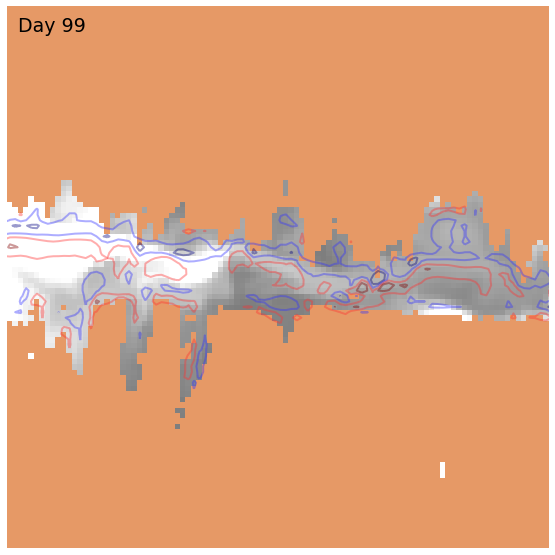

In [8]:
# Plotting parameters
nancol = (0.9,0.6,0.4)
tr_cmap = copy.copy(matplotlib.cm.get_cmap("binary"))
tr_cmap.set_bad(color=nancol)

for tr in [1,2,3]:
    for t in np.arange(0, 100, 1):
        Zdict = {1: 1300, 2:850, 3:450}
        xlimdict = {1: [0, 60e3], 2: [-10e3, 50e3], 3:[15e3, 75e3]}
        levelsdict = {
            1: [-0.2, -0.075, 0.075, 0.2],
            2: [-0.5, -0.15, 0.15, 0.5],
            3: [-0.3, -0.1, 0.1, 0.3]
        }
        expnames = {
            1: "realistic",
            2: "crest",
            3: "bottom",
        }

        vmax = 1
        vmin = 2.5e-3

        fig = plt.figure(num=1, figsize=(8,8))
        fig.clf()
        ax = plt.subplot(111)
        ds[f'TRAC0{tr}'] = ds[f'TRAC0{tr}'].where(ds[f'TRAC0{tr}']>vmin, vmin)
        ds[f'TRAC0{tr}'] = ds[f'TRAC0{tr}'].where(ds['hFacC']!=0.)
        PC = ds[f'TRAC0{tr}'].sel(Z=Zdict[tr], method='nearest').isel(time=t).plot(ax=ax, cmap=tr_cmap, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), extend='both')
        PC.colorbar.remove()
        (ζ/f).sel(Z=Zdict[tr], method='nearest').isel(time=t).plot.contour(linewidths=2., ax=ax, alpha=0.4, levels=levelsdict[tr], colors=[(0,0,0.5), (0.2, 0.2, 1.), (1., 0.2, 0.2), (0.5,0,0)])
        ax.set_xlim(xlimdict[tr])
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        ax.annotate(f"Day {t}", xy=(0.02, 0.955), xycoords="axes fraction", fontsize=19)
        plt.tight_layout()
        plt.savefig(f"../../figures/BBTRE-tracer/movies/{expnames[tr]}/{expnames[tr]}_{str(t).zfill(4)}.png", dpi=150., bbox_inches='tight', pad_inches = 0)